# 05 - Evaluation und Metriken

Umfassende Evaluation der RAG-Systeme mit automatischen Metriken und qualitativer Analyse.

## Ziele:
- BLEU und ROUGE Scores berechnen
- Retrieval-Qualität bewerten
- Vergleichende Analyse erstellen
- Ergebnisse visualisieren

In [2]:
# Imports
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from collections import defaultdict
import time

# Evaluation Metriken
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import nltk

# NLTK Downloads (falls noch nicht vorhanden)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

print("Imports und NLTK-Setup erfolgreich")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...


Imports und NLTK-Setup erfolgreich


[nltk_data]   Unzipping tokenizers\punkt.zip.


## Daten laden

In [3]:
# Alle bisherigen Ergebnisse laden
with open('../data/faq_korpus.json', 'r', encoding='utf-8') as f:
    faq_documents = json.load(f)

test_questions = pd.read_csv('../data/fragenliste.csv')
vector_results = pd.read_csv('../results/vector_retrieval_results.csv')
graph_results = pd.read_csv('../results/graph_retrieval_results.csv')
rag_results = pd.read_csv('../results/rag_pipeline_results.csv')

with open('../results/detailed_answers.json', 'r', encoding='utf-8') as f:
    detailed_answers = json.load(f)

print(f"Alle Ergebnisse geladen:")
print(f"   - FAQ-Korpus: {len(faq_documents)} Dokumente")
print(f"   - Testfragen: {len(test_questions)} Fragen")
print(f"   - Vector Retrieval: {len(vector_results)} Ergebnisse")
print(f"   - Graph Retrieval: {len(graph_results)} Ergebnisse")
print(f"   - RAG Pipeline: {len(rag_results)} Antworten")

Alle Ergebnisse geladen:
   - FAQ-Korpus: 15 Dokumente
   - Testfragen: 12 Fragen
   - Vector Retrieval: 12 Ergebnisse
   - Graph Retrieval: 12 Ergebnisse
   - RAG Pipeline: 36 Antworten


## Referenz-Antworten vorbereiten

Für BLEU/ROUGE brauchen wir Referenz-Antworten. Wir nutzen die Original-FAQ-Antworten als Ground Truth.

In [4]:
# Mapping von Fragen zu erwarteten Antworten erstellen
def create_reference_mapping():
    """Erstellt Mapping von Testfragen zu passenden FAQ-Antworten"""
    reference_map = {}

    # Manuelle Zuordnung basierend auf Themen (vereinfacht für Demo)
    topic_mapping = {
        'q001': 'doc_001',  # "Was ist RAG?" -> RAG Basics
        'q002': 'doc_003',  # "Unterschied Vektor/Graph" -> Graph Retrieval
        'q003': 'doc_004',  # "Evaluationsmetriken" -> Evaluation
        'q004': 'doc_012',  # "Performance optimieren" -> Optimization
        'q005': 'doc_013',  # "Kosten" -> Business
        'q006': 'doc_010',  # "Hybrid Retrieval" -> Advanced Techniques
        'q007': 'doc_011',  # "Vector Database" -> Infrastructure
        'q008': 'doc_007',  # "Probleme lösen" -> Troubleshooting
        'q009': 'doc_014',  # "Knowledge Graphs" -> Graph Implementation
        'q010': 'doc_006',  # "Chunk-Size" -> Data Processing
        'q011': 'doc_015',  # "Zukunftstrends" -> Future Trends
        'q012': 'doc_012'   # "Embedding-Qualität" -> Optimization
    }

    # FAQ-Dokumente als Dict für schnellen Zugriff
    faq_dict = {doc['id']: doc for doc in faq_documents}

    for question_id, doc_id in topic_mapping.items():
        if doc_id in faq_dict:
            reference_map[question_id] = faq_dict[doc_id]['answer']
        else:
            # Fallback: erste passende Antwort
            reference_map[question_id] = faq_documents[0]['answer']

    return reference_map

reference_answers = create_reference_mapping()
print(f"Referenz-Antworten erstellt für {len(reference_answers)} Fragen")

# Beispiel anzeigen
example_q = 'q001'
print(f"\nBeispiel - {example_q}:")
print(f"Referenz: {reference_answers[example_q][:100]}...")

Referenz-Antworten erstellt für 12 Fragen

Beispiel - q001:
Referenz: RAG ist eine Technik, die Large Language Models mit externen Wissensquellen verbindet. Das Modell ka...


## BLEU Score Berechnung

In [5]:
def calculate_bleu_score(candidate, reference):
    """Berechnet BLEU Score zwischen candidate und reference"""
    try:
        # Tokenize
        reference_tokens = reference.lower().split()
        candidate_tokens = candidate.lower().split()

        # BLEU mit Smoothing für kurze Texte
        smoothing = SmoothingFunction()
        bleu_score = sentence_bleu(
            [reference_tokens],
            candidate_tokens,
            smoothing_function=smoothing.method1
        )
        return bleu_score
    except:
        return 0.0

def calculate_bleu_scores_for_method(method_name):
    """Berechnet BLEU Scores für alle Antworten einer Methode"""
    bleu_scores = []

    for question_id in reference_answers.keys():
        answer_key = f"{question_id}_{method_name}"

        if answer_key in detailed_answers:
            candidate = detailed_answers[answer_key]['answer']
            reference = reference_answers[question_id]

            bleu_score = calculate_bleu_score(candidate, reference)
            bleu_scores.append({
                'question_id': question_id,
                'method': method_name,
                'bleu_score': bleu_score,
                'difficulty': detailed_answers[answer_key]['difficulty']
            })

    return bleu_scores

# BLEU Scores für alle Methoden berechnen
print("Berechne BLEU Scores...")

all_bleu_scores = []
for method in ['vector', 'graph', 'baseline']:
    method_scores = calculate_bleu_scores_for_method(method)
    all_bleu_scores.extend(method_scores)
    avg_bleu = np.mean([s['bleu_score'] for s in method_scores])
    print(f"   {method}: {avg_bleu:.3f} (avg)")

bleu_df = pd.DataFrame(all_bleu_scores)
print(f"BLEU Scores berechnet: {len(bleu_df)} Bewertungen")

Berechne BLEU Scores...
   vector: 0.137 (avg)
   graph: 0.074 (avg)
   baseline: 0.003 (avg)
BLEU Scores berechnet: 36 Bewertungen


## ROUGE Score Berechnung

In [6]:
def calculate_rouge_scores_for_method(method_name):
    """Berechnet ROUGE Scores für alle Antworten einer Methode"""
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)
    rouge_scores = []

    for question_id in reference_answers.keys():
        answer_key = f"{question_id}_{method_name}"

        if answer_key in detailed_answers:
            candidate = detailed_answers[answer_key]['answer']
            reference = reference_answers[question_id]

            scores = scorer.score(reference, candidate)

            rouge_scores.append({
                'question_id': question_id,
                'method': method_name,
                'rouge1_f': scores['rouge1'].fmeasure,
                'rouge2_f': scores['rouge2'].fmeasure,
                'rougeL_f': scores['rougeL'].fmeasure,
                'difficulty': detailed_answers[answer_key]['difficulty']
            })

    return rouge_scores

# ROUGE Scores für alle Methoden berechnen
print("Berechne ROUGE Scores...")

all_rouge_scores = []
for method in ['vector', 'graph', 'baseline']:
    method_scores = calculate_rouge_scores_for_method(method)
    all_rouge_scores.extend(method_scores)
    avg_rouge1 = np.mean([s['rouge1_f'] for s in method_scores])
    print(f"   {method}: {avg_rouge1:.3f} (ROUGE-1)")

rouge_df = pd.DataFrame(all_rouge_scores)
print(f"ROUGE Scores berechnet: {len(rouge_df)} Bewertungen")

Berechne ROUGE Scores...
   vector: 0.506 (ROUGE-1)
   graph: 0.348 (ROUGE-1)
   baseline: 0.136 (ROUGE-1)
ROUGE Scores berechnet: 36 Bewertungen


## Retrieval-Qualität Analyse

In [7]:
def analyze_retrieval_quality():
    """Analysiert die Qualität der Retrieval-Ergebnisse"""
    retrieval_analysis = []

    # Vector Retrieval Analyse
    for _, row in vector_results.iterrows():
        retrieval_analysis.append({
            'question_id': row['question_id'],
            'method': 'vector',
            'retrieved_doc': row['retrieved_doc_id'],
            'retrieval_score': row['retrieval_score'],
            'difficulty': row['difficulty']
        })

    # Graph Retrieval Analyse
    for _, row in graph_results.iterrows():
        if row['retrieved_doc_id'] != 'NO_RESULT':
            retrieval_analysis.append({
                'question_id': row['question_id'],
                'method': 'graph',
                'retrieved_doc': row['retrieved_doc_id'],
                'retrieval_score': row['retrieval_score'],
                'difficulty': row['difficulty']
            })

    return pd.DataFrame(retrieval_analysis)

retrieval_df = analyze_retrieval_quality()

# Retrieval Success Rate
vector_success = len(vector_results[vector_results['retrieval_score'] > 0]) / len(vector_results)
graph_success = len(graph_results[graph_results['retrieved_doc_id'] != 'NO_RESULT']) / len(graph_results)

print("=== ANALYSE VON RETRIEVAL-QUALITÄT ===")
print(f"Vector Retrieval Success Rate: {vector_success:.2%}")
print(f"Graph Retrieval Success Rate: {graph_success:.2%}")
print(f"Vector Avg Score: {vector_results['retrieval_score'].mean():.3f}")
print(f"Graph Avg Score: {graph_results['retrieval_score'].mean():.3f}")

=== ANALYSE VON RETRIEVAL-QUALITÄT ===
Vector Retrieval Success Rate: 100.00%
Graph Retrieval Success Rate: 66.67%
Vector Avg Score: 0.645
Graph Avg Score: 4.917


## Kombinierte Evaluation (Tabelle)

In [8]:
# Alle Metriken in einer Tabelle kombinieren
def create_combined_evaluation():
    """Erstellt kombinierte Evaluation-Tabelle"""
    combined_results = []

    methods = ['vector', 'graph', 'baseline']

    for method in methods:
        # BLEU Scores für diese Methode
        method_bleu = bleu_df[bleu_df['method'] == method]
        avg_bleu = method_bleu['bleu_score'].mean()

        # ROUGE Scores für diese Methode
        method_rouge = rouge_df[rouge_df['method'] == method]
        avg_rouge1 = method_rouge['rouge1_f'].mean()
        avg_rouge2 = method_rouge['rouge2_f'].mean()
        avg_rougeL = method_rouge['rougeL_f'].mean()

        # Retrieval Scores
        if method == 'vector':
            avg_retrieval = vector_results['retrieval_score'].mean()
            success_rate = vector_success
        elif method == 'graph':
            avg_retrieval = graph_results['retrieval_score'].mean()
            success_rate = graph_success
        else:
            avg_retrieval = 0
            success_rate = 0

        # Antwortzeit
        method_rag = rag_results[rag_results['method'] == method]
        avg_time = method_rag['retrieval_time'].mean()

        combined_results.append({
            'method': method,
            'bleu_score': avg_bleu,
            'rouge1_f': avg_rouge1,
            'rouge2_f': avg_rouge2,
            'rougeL_f': avg_rougeL,
            'avg_retrieval_score': avg_retrieval,
            'success_rate': success_rate,
            'avg_response_time': avg_time,
            'num_questions': len(method_bleu)
        })

    return pd.DataFrame(combined_results)

evaluation_summary = create_combined_evaluation()

print("=== KOMBINIERTE EVALUATION ===")
print(evaluation_summary.round(3).to_string(index=False))

=== KOMBINIERTE EVALUATION ===
  method  bleu_score  rouge1_f  rouge2_f  rougeL_f  avg_retrieval_score  success_rate  avg_response_time  num_questions
  vector       0.137     0.506     0.316     0.398                0.645         1.000              1.117             12
   graph       0.074     0.348     0.195     0.241                4.917         0.667              0.764             12
baseline       0.003     0.136     0.031     0.088                0.000         0.000              3.007             12


## Schwierigkeitsgrad-Analyse

In [9]:
# Analyse nach Schwierigkeitsgrad
def analyze_by_difficulty():
    """Analysiert Performance nach Schwierigkeitsgrad"""

    # BLEU nach Schwierigkeit und Methode
    difficulty_bleu = bleu_df.groupby(['difficulty', 'method'])['bleu_score'].mean().unstack().round(3)

    # ROUGE-1 nach Schwierigkeit und Methode
    difficulty_rouge = rouge_df.groupby(['difficulty', 'method'])['rouge1_f'].mean().unstack().round(3)

    return difficulty_bleu, difficulty_rouge

difficulty_bleu, difficulty_rouge = analyze_by_difficulty()

print("=== BLEU SCORES NACH SCHWIERIGKEIT ===")
print(difficulty_bleu)

print("\n=== ROUGE-1 SCORES NACH SCHWIERIGKEIT ===")
print(difficulty_rouge)

# Beste/schlechteste Ergebnisse
print("\n=== TOP 3 BLEU SCORES ===")
top_bleu = bleu_df.nlargest(3, 'bleu_score')[['question_id', 'method', 'bleu_score', 'difficulty']]
print(top_bleu.to_string(index=False))

print("\n=== SCHLECHTESTE 3 BLEU SCORES ===")
bottom_bleu = bleu_df.nsmallest(3, 'bleu_score')[['question_id', 'method', 'bleu_score', 'difficulty']]
print(bottom_bleu.to_string(index=False))

=== BLEU SCORES NACH SCHWIERIGKEIT ===
method      baseline  graph  vector
difficulty                         
easy           0.006  0.052   0.244
hard           0.002  0.010   0.042
medium         0.003  0.139   0.148

=== ROUGE-1 SCORES NACH SCHWIERIGKEIT ===
method      baseline  graph  vector
difficulty                         
easy           0.135  0.314   0.599
hard           0.112  0.180   0.375
medium         0.156  0.502   0.555

=== TOP 3 BLEU SCORES ===
question_id method  bleu_score difficulty
       q001 vector    0.431476       easy
       q008  graph    0.347187     medium
       q008 vector    0.307844     medium

=== SCHLECHTESTE 3 BLEU SCORES ===
question_id method  bleu_score difficulty
       q004  graph         0.0       hard
       q005  graph         0.0       easy
       q010  graph         0.0     medium


## Visualisierungen erstellen

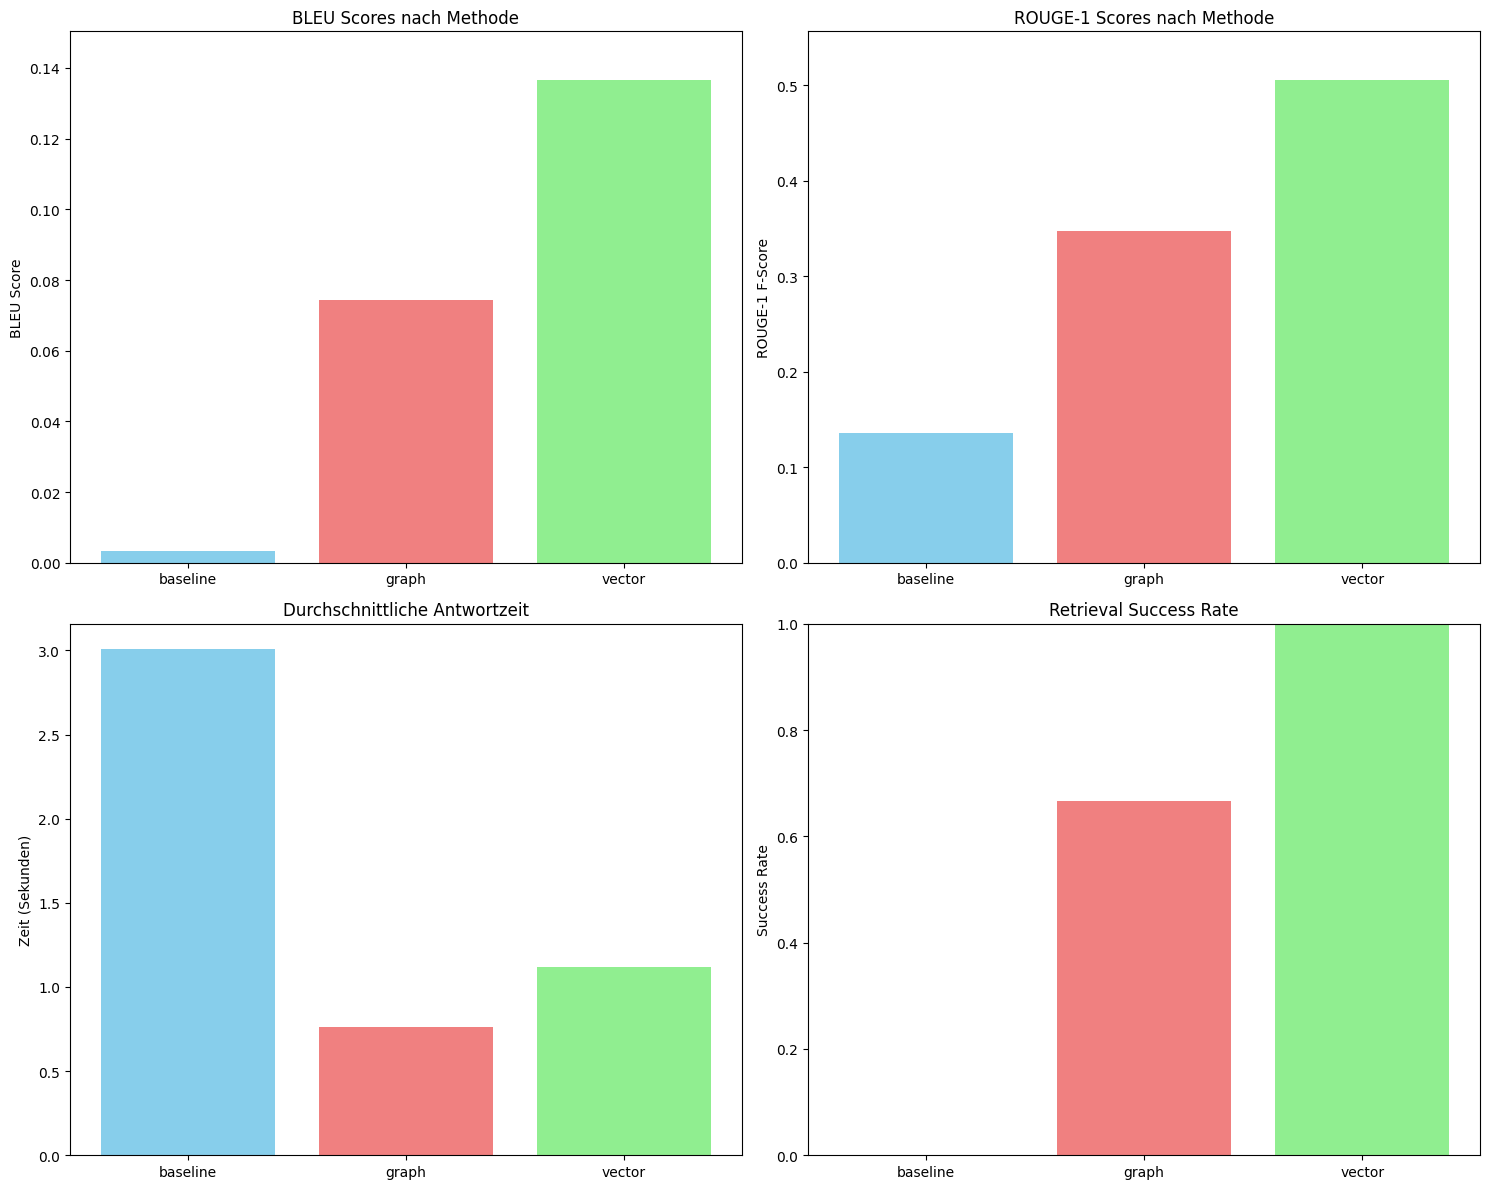

Visualisierungen erstellt und gespeichert


In [16]:
# Visualisierungen der Ergebnisse
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. BLEU Scores Vergleich
bleu_by_method = bleu_df.groupby('method')['bleu_score'].mean()
axes[0,0].bar(bleu_by_method.index, bleu_by_method.values, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0,0].set_title('BLEU Scores nach Methode')
axes[0,0].set_ylabel('BLEU Score')
axes[0,0].set_ylim(0, max(bleu_by_method.values) * 1.1)

# 2. ROUGE-1 Scores Vergleich
rouge1_by_method = rouge_df.groupby('method')['rouge1_f'].mean()
axes[0,1].bar(rouge1_by_method.index, rouge1_by_method.values, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0,1].set_title('ROUGE-1 Scores nach Methode')
axes[0,1].set_ylabel('ROUGE-1 F-Score')
axes[0,1].set_ylim(0, max(rouge1_by_method.values) * 1.1)

# 3. Antwortzeiten
time_by_method = rag_results.groupby('method')['retrieval_time'].mean()
axes[1,0].bar(time_by_method.index, time_by_method.values, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1,0].set_title('Durchschnittliche Antwortzeit')
axes[1,0].set_ylabel('Zeit (Sekunden)')

# 4. Retrieval Success Rate
success_rates = [0, graph_success, vector_success]
methods = ['baseline','graph','vector']
axes[1,1].bar(methods, success_rates, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1,1].set_title('Retrieval Success Rate')
axes[1,1].set_ylabel('Success Rate')
axes[1,1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig('../results/evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualisierungen erstellt und gespeichert")

## Detaillierte Performance-Matrix

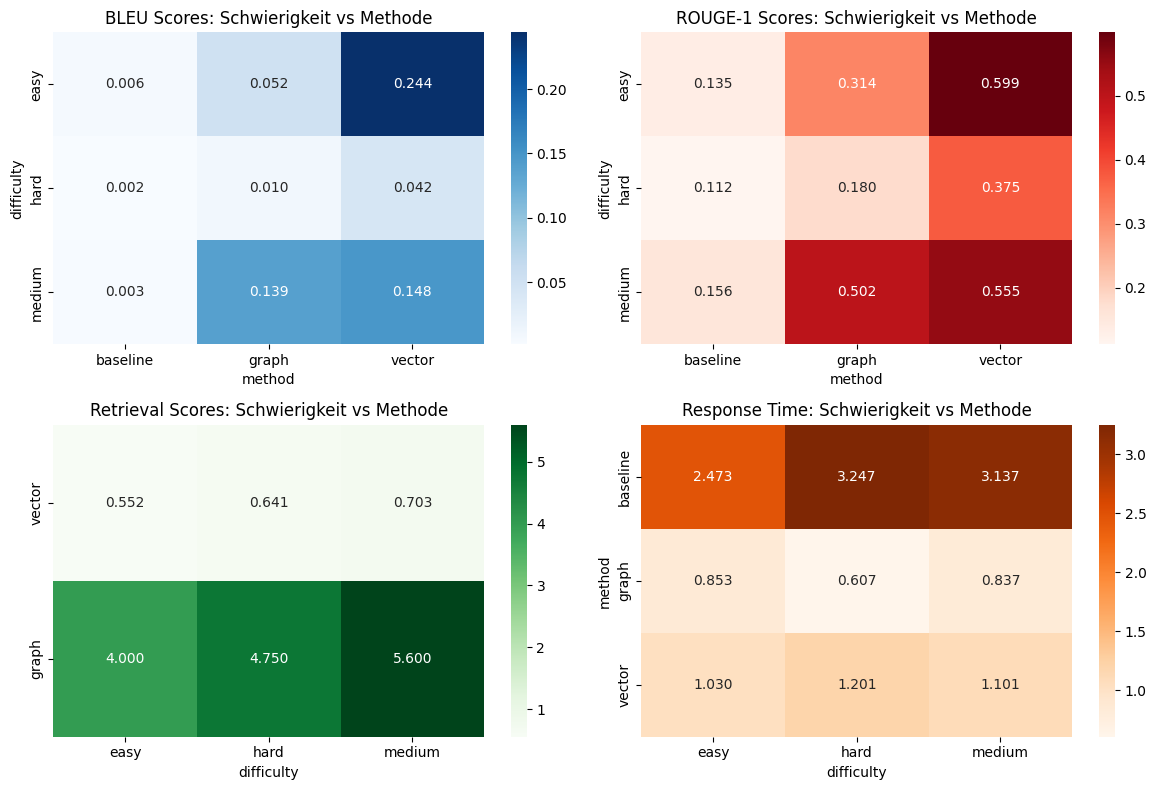

Performance-Heatmaps erstellt


In [11]:
# Heatmap für Performance nach Schwierigkeit
plt.figure(figsize=(12, 8))

# BLEU Heatmap
plt.subplot(2, 2, 1)
sns.heatmap(difficulty_bleu, annot=True, cmap='Blues', fmt='.3f')
plt.title('BLEU Scores: Schwierigkeit vs Methode')

# ROUGE-1 Heatmap
plt.subplot(2, 2, 2)
sns.heatmap(difficulty_rouge, annot=True, cmap='Reds', fmt='.3f')
plt.title('ROUGE-1 Scores: Schwierigkeit vs Methode')

# Retrieval Scores nach Schwierigkeit
plt.subplot(2, 2, 3)
vector_by_diff = vector_results.groupby('difficulty')['retrieval_score'].mean()
graph_by_diff = graph_results.groupby('difficulty')['retrieval_score'].mean()

retrieval_matrix = pd.DataFrame({
    'vector': vector_by_diff,
    'graph': graph_by_diff
}).fillna(0)

sns.heatmap(retrieval_matrix.T, annot=True, cmap='Greens', fmt='.3f')
plt.title('Retrieval Scores: Schwierigkeit vs Methode')

# Response Time Heatmap
plt.subplot(2, 2, 4)
time_matrix = rag_results.groupby(['difficulty', 'method'])['retrieval_time'].mean().unstack()
sns.heatmap(time_matrix.T, annot=True, cmap='Oranges', fmt='.3f')
plt.title('Response Time: Schwierigkeit vs Methode')

plt.tight_layout()
plt.savefig('../results/performance_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

print("Performance-Heatmaps erstellt")

## Qualitative Analyse - Beste und schlechteste Antworten

In [12]:
def qualitative_analysis():
    """Zeigt beste und schlechteste Antworten für qualitative Analyse"""

    print("=== QUALITATIVE ANALYSE ===")

    # Beste BLEU Score Antwort
    best_bleu_row = bleu_df.loc[bleu_df['bleu_score'].idxmax()]
    best_answer_key = f"{best_bleu_row['question_id']}_{best_bleu_row['method']}"

    print(f"\nBESTE ANTWORT (BLEU: {best_bleu_row['bleu_score']:.3f})")
    print(f"Frage ({best_bleu_row['question_id']}): {detailed_answers[best_answer_key]['question']}")
    print(f"Methode: {best_bleu_row['method']}")
    print(f"Antwort: {detailed_answers[best_answer_key]['answer'][:300]}...")
    print(f"Referenz: {reference_answers[best_bleu_row['question_id']][:300]}...")

    # Schlechteste BLEU Score Antwort
    worst_bleu_row = bleu_df.loc[bleu_df['bleu_score'].idxmin()]
    worst_answer_key = f"{worst_bleu_row['question_id']}_{worst_bleu_row['method']}"

    print(f"\nSCHLECHTESTE ANTWORT (BLEU: {worst_bleu_row['bleu_score']:.3f})")
    print(f"Frage ({worst_bleu_row['question_id']}): {detailed_answers[worst_answer_key]['question']}")
    print(f"Methode: {worst_bleu_row['method']}")
    print(f"Antwort: {detailed_answers[worst_answer_key]['answer'][:300]}...")
    print(f"Referenz: {reference_answers[worst_bleu_row['question_id']][:300]}...")

    # Vergleich für eine spezifische Frage
    print(f"\nMETHODENVERGLEICH FÜR FRAGE q002")
    example_q = 'q002'
    for method in ['vector', 'graph', 'baseline']:
        answer_key = f"{example_q}_{method}"
        if answer_key in detailed_answers:
            bleu_score = bleu_df[(bleu_df['question_id'] == example_q) & (bleu_df['method'] == method)]['bleu_score'].iloc[0]
            print(f"\n--- {method.upper()} (BLEU: {bleu_score:.3f}) ---")
            print(f"{detailed_answers[answer_key]['answer'][:200]}...")

qualitative_analysis()

=== QUALITATIVE ANALYSE ===

BESTE ANTWORT (BLEU: 0.431)
Frage (q001): Erkläre mir RAG in einfachen Worten
Methode: vector
Antwort: RAG (Retrieval-Augmented Generation) ist eine Technik, bei der ein großes Sprachmodell mit externen Wissensquellen verbunden wird. Das Modell kann relevante Informationen aus einer Wissensbasis abrufen und diese in seine Antworten einbeziehen. Dadurch werden Halluzinationen reduziert und die Antwort...
Referenz: RAG ist eine Technik, die Large Language Models mit externen Wissensquellen verbindet. Das Modell kann relevante Informationen aus einer Wissensbasis abrufen und diese in seine Antworten einbeziehen. Dies reduziert Halluzinationen und ermöglicht aktuellere Informationen....

SCHLECHTESTE ANTWORT (BLEU: 0.000)
Frage (q004): Wie optimiere ich die Performance meines RAG-Systems?
Methode: graph
Antwort: Keine relevanten Dokumente im Knowledge Graph gefunden....
Referenz: Fine-tuning von Embedding-Modellen auf domänenspezifische Daten verbessert Retriev

## Zusammenfassung und Empfehlungen

In [13]:
def generate_summary_report():
    """Generiert Zusammenfassung der Evaluation"""

    print("=" * 60)
    print("EVALUATION ZUSAMMENFASSUNG")
    print("=" * 60)

    # Gewinner pro Metrik
    bleu_winner = evaluation_summary.loc[evaluation_summary['bleu_score'].idxmax(), 'method']
    rouge_winner = evaluation_summary.loc[evaluation_summary['rouge1_f'].idxmax(), 'method']
    speed_winner = evaluation_summary.loc[evaluation_summary['avg_response_time'].idxmin(), 'method']
    retrieval_winner = evaluation_summary.loc[evaluation_summary['avg_retrieval_score'].idxmax(), 'method']

    print(f"\nGEWINNER PRO KATEGORIE:")
    print(f"   Beste Textqualität (BLEU): {bleu_winner}")
    print(f"   Beste Übereinstimmung (ROUGE): {rouge_winner}")
    print(f"   Bestes Retrieval: {retrieval_winner}")
    print(f"   Schnellste Antworten: {speed_winner}")

    # Schwierigkeitsgrad-Performance
    print(f"\nPERFORMANCE NACH SCHWIERIGKEIT:")
    for difficulty in ['easy', 'medium', 'hard']:
        if difficulty in difficulty_bleu.index:
            best_method = difficulty_bleu.loc[difficulty].idxmax()
            best_score = difficulty_bleu.loc[difficulty].max()
            print(f"   {difficulty.upper()}: {best_method} ({best_score:.3f} BLEU)")

    # Empfehlungen
    print(f"\nEMPFEHLUNGEN:")

    # Vector vs Graph
    vector_avg = evaluation_summary[evaluation_summary['method'] == 'vector']['bleu_score'].iloc[0]
    graph_avg = evaluation_summary[evaluation_summary['method'] == 'graph']['bleu_score'].iloc[0]

    if vector_avg > graph_avg:
        print(f"   Vector Retrieval übertrifft Graph Retrieval um {((vector_avg/graph_avg-1)*100):.1f}%")
    else:
        print(f"   Graph Retrieval übertrifft Vector Retrieval um {((graph_avg/vector_avg-1)*100):.1f}%")

    # RAG vs Baseline
    rag_avg = max(vector_avg, graph_avg)
    baseline_avg = evaluation_summary[evaluation_summary['method'] == 'baseline']['bleu_score'].iloc[0]

    if rag_avg > baseline_avg:
        print(f"   RAG verbessert Antwortqualität um {((rag_avg/baseline_avg-1)*100):.1f}% vs Baseline")
    else:
        print(f"   Baseline teilweise besser - Retrieval-Qualität überprüfen")

    # Performance-Trade-offs
    vector_time = evaluation_summary[evaluation_summary['method'] == 'vector']['avg_response_time'].iloc[0]
    graph_time = evaluation_summary[evaluation_summary['method'] == 'graph']['avg_response_time'].iloc[0]

    if vector_time < graph_time:
        print(f"   Vector Retrieval ist {((graph_time/vector_time-1)*100):.1f}% schneller")
    else:
        print(f"   Graph Retrieval ist {((vector_time/graph_time-1)*100):.1f}% schneller")

    print("\n" + "=" * 60)

generate_summary_report()

EVALUATION ZUSAMMENFASSUNG

GEWINNER PRO KATEGORIE:
   Beste Textqualität (BLEU): vector
   Beste Übereinstimmung (ROUGE): vector
   Bestes Retrieval: graph
   Schnellste Antworten: graph

PERFORMANCE NACH SCHWIERIGKEIT:
   EASY: vector (0.244 BLEU)
   MEDIUM: vector (0.148 BLEU)
   HARD: vector (0.042 BLEU)

EMPFEHLUNGEN:
   Vector Retrieval übertrifft Graph Retrieval um 84.2%
   RAG verbessert Antwortqualität um 3966.5% vs Baseline
   Graph Retrieval ist 46.2% schneller



## Finale Ergebnisse speichern

In [14]:
# Alle Evaluation-Ergebnisse speichern
bleu_df.to_csv('../results/bleu_scores.csv', index=False, encoding='utf-8')
rouge_df.to_csv('../results/rouge_scores.csv', index=False, encoding='utf-8')
evaluation_summary.to_csv('../results/evaluation_summary.csv', index=False, encoding='utf-8')

# Schwierigkeitsgrad-Analysen speichern
difficulty_bleu.to_csv('../results/bleu_by_difficulty.csv', encoding='utf-8')
difficulty_rouge.to_csv('../results/rouge_by_difficulty.csv', encoding='utf-8')

# Finale Metriken-Übersicht
final_metrics = {
    'evaluation_date': time.strftime('%Y-%m-%d %H:%M:%S'),
    'num_test_questions': len(test_questions),
    'num_faq_documents': len(faq_documents),
    'methods_compared': ['vector', 'graph', 'baseline'],
    'best_overall_method': evaluation_summary.loc[evaluation_summary['bleu_score'].idxmax(), 'method'],
    'avg_bleu_vector': float(evaluation_summary[evaluation_summary['method'] == 'vector']['bleu_score'].iloc[0]),
    'avg_bleu_graph': float(evaluation_summary[evaluation_summary['method'] == 'graph']['bleu_score'].iloc[0]),
    'avg_bleu_baseline': float(evaluation_summary[evaluation_summary['method'] == 'baseline']['bleu_score'].iloc[0]),
    'vector_success_rate': float(vector_success),
    'graph_success_rate': float(graph_success)
}

with open('../results/final_metrics.json', 'w', encoding='utf-8') as f:
    json.dump(final_metrics, f, ensure_ascii=False, indent=2)

print("Alle Evaluation-Ergebnisse gespeichert:")
print("   - ../results/bleu_scores.csv")
print("   - ../results/rouge_scores.csv")
print("   - ../results/evaluation_summary.csv")
print("   - ../results/bleu_by_difficulty.csv")
print("   - ../results/rouge_by_difficulty.csv")
print("   - ../results/evaluation_plots.png")
print("   - ../results/performance_heatmaps.png")
print("   - ../results/final_metrics.json")

Alle Evaluation-Ergebnisse gespeichert:
   - ../results/bleu_scores.csv
   - ../results/rouge_scores.csv
   - ../results/evaluation_summary.csv
   - ../results/bleu_by_difficulty.csv
   - ../results/rouge_by_difficulty.csv
   - ../results/evaluation_plots.png
   - ../results/performance_heatmaps.png
   - ../results/final_metrics.json
